In [1]:
import time
import os
import math
import cv2
import numpy as np
import pandas as pd
import pyautogui as pa
import shutil
import imageio
from PIL import Image, ImageDraw
import random
from scipy.stats import norm, kstest, sem, ttest_ind, linregress

from lib.analysis.trace_metrics import TraceMetrics
from lib.analysis.false_discovery_control import false_discovery_control
from lib.auto_GUI.auto_PhotoZ import AutoPhotoZ
from lib.analysis.laminar_dist import *
from lib.file.TIF import *
from lib.analysis.align import ImageAlign
from lib.utilities import *
from lib.file.ROI_writer import ROIFileWriter
from lib.file.ROI_reader import ROIFileReader
from lib.analysis.barrel_roi import Barrel_ROI_Creator

# This script uses the export summary created by the OrchestraZ auto export application feature
#  to analyze the data


In [2]:
# load trace files from the following directory
data_dir = "C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/theta-Calcrl/"
export_summary = data_dir + "export_summary_calcrl.csv"
catalog_file = data_dir + "theta_catalog.csv"

camera_program = 4
um_per_px = 6.0 #um

# Movie maker settings
enable_photoZ_interact = False
initialize_photoZ = False

In [3]:
def read_traces_file(filename): 
    data_arr = pd.read_csv(filename,
                                 sep='\t',
                                 header=0)
    return data_arr

# open export summary csv
df = pd.read_csv(export_summary)

# open catalog file
catalog_df = pd.read_csv(catalog_file)

# normalize latency
actual_stim_time = 48.9
df['latency'] = df['latency'] - actual_stim_time
df

,ROI,amp,snr,latency,halfwidth,ROI_Set,Date,Slice,Location,Recording,trace,snr_array
0,1,2.91594,17.838500,0.5779,4.97997,1_2_1roi,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,1,2,1,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...
1,2,4.06318,12.452700,0.3830,3.77557,1_2_1roi,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,1,2,1,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...
2,3,3.71713,15.952000,0.5110,4.27915,1_2_1roi,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,1,2,1,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...
3,4,3.24216,11.143000,0.8073,4.43570,1_2_1roi,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,1,2,1,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...
4,5,3.90170,10.234600,0.1509,4.31240,1_2_1roi,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,1,2,1,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...
...,...,...,...,...,...,...,...,...,...,...,...,...
265,4,1.39715,1.937730,-3.5103,3.86293,NaN,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,1,2,7,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...
266,1,2.66441,2.761160,4.3184,3.53329,NaN,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,1,2,8,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...
267,2,2.16470,1.525130,-3.6988,4.80886,NaN,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,1,2,8,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...
268,3,3.31798,1.986220,-2.7124,3.39042,NaN,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,1,2,8,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...


C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/theta-Calcrl/07-26-24/selected_zda 1 2 1 1


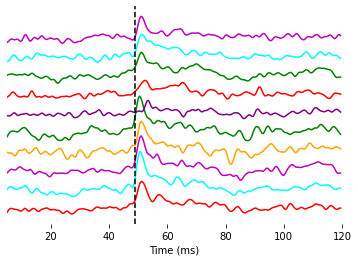

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/theta-Calcrl/07-26-24/selected_zda 1 2 1 2


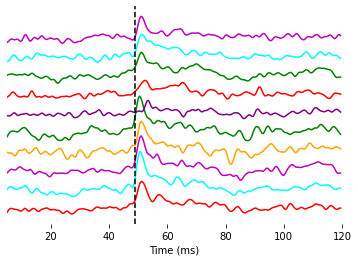

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/theta-Calcrl/07-26-24/selected_zda 1 2 1 3


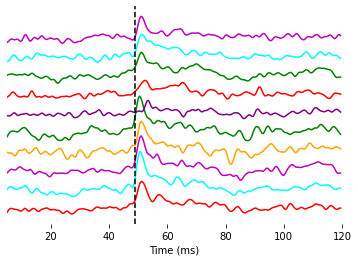

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/theta-Calcrl/07-26-24/selected_zda 1 2 1 4


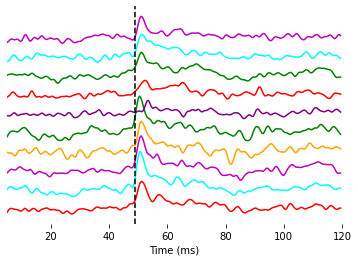

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/theta-Calcrl/07-26-24/selected_zda 1 2 1 5


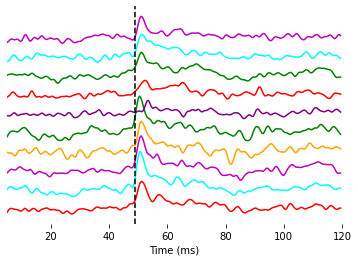

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/theta-Calcrl/07-26-24/selected_zda 1 2 1 6


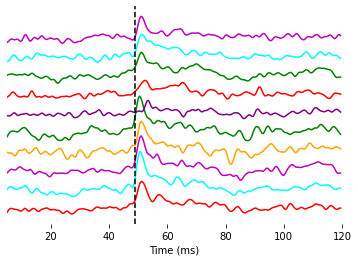

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/theta-Calcrl/07-26-24/selected_zda 1 2 1 7


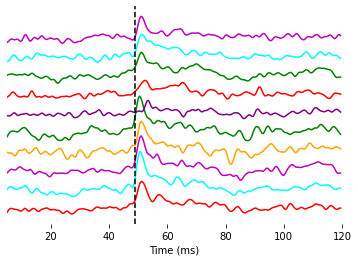

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/theta-Calcrl/07-26-24/selected_zda 1 2 1 8


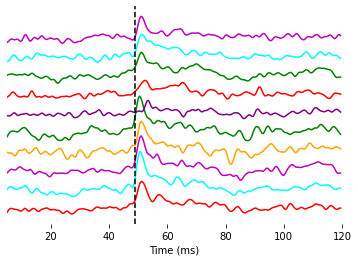

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/theta-Calcrl/07-26-24/selected_zda 1 2 1 9


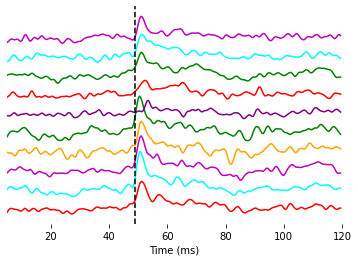

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/theta-Calcrl/07-26-24/selected_zda 1 2 1 10


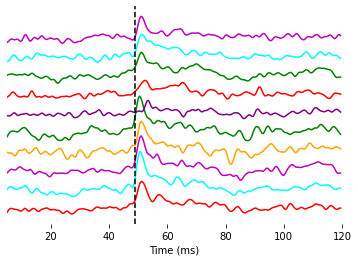

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/theta-Calcrl/07-26-24/selected_zda 1 2 2 1


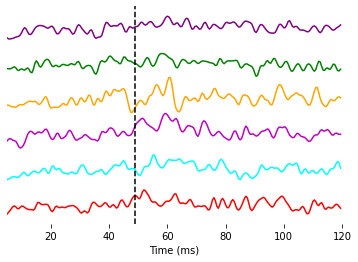

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/theta-Calcrl/07-26-24/selected_zda 1 2 2 2


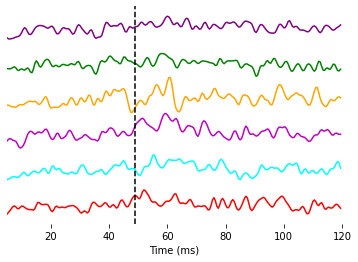

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/theta-Calcrl/07-26-24/selected_zda 1 2 2 3


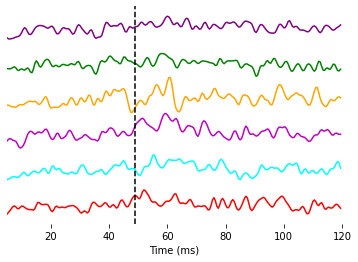

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/theta-Calcrl/07-26-24/selected_zda 1 2 2 4


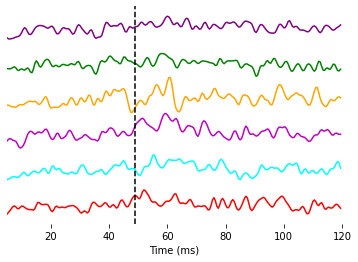

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/theta-Calcrl/07-26-24/selected_zda 1 2 2 5


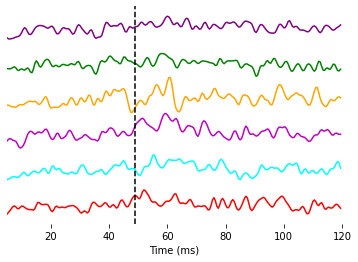

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/theta-Calcrl/07-26-24/selected_zda 1 2 2 6


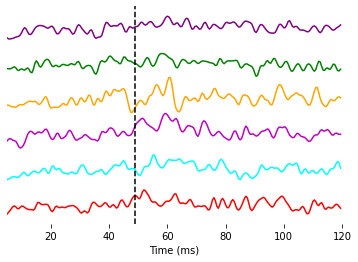

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/theta-Calcrl/07-26-24/selected_zda 1 2 3 1


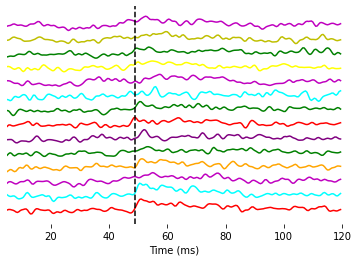

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/theta-Calcrl/07-26-24/selected_zda 1 2 3 2


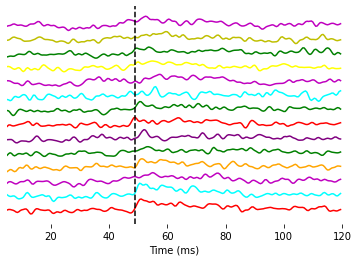

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/theta-Calcrl/07-26-24/selected_zda 1 2 3 3


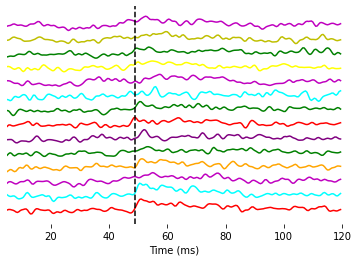

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/theta-Calcrl/07-26-24/selected_zda 1 2 3 4


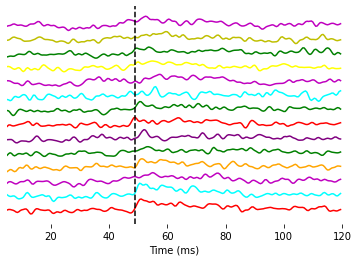

In [4]:
# plot traces
n_plots = 20
for date in df['Date'].unique():
    df_date = df[df['Date'] == date]
    for slic_id in df_date['Slice'].unique():
        df_slic = df_date[df_date['Slice'] == slic_id]
        for loc_id in df_slic['Location'].unique():
            df_loc = df_slic[df_slic['Location'] == loc_id]
            for rec_id in df_loc['Recording'].unique():
                df_rec = df_loc[df_loc['Recording'] == rec_id]
                for roi_id in df_rec['ROI'].unique():
                    df_roi = df_rec[df_rec['ROI'] == roi_id]

                    if n_plots == 0:
                        continue

                    # trace filename
                    trace_filename = df_roi['trace'].values[0]
                    trace = read_traces_file(trace_filename)

                    tm = TraceMetrics(trace)
                    print(date, slic_id, loc_id, rec_id, roi_id)
                    tm.show_traces(measure_window=[10, 240], 
                            legend=False, 
                            colors=['r', 'cyan', 'm', 'orange', 'green', 'purple',
                                    'r', 'green', 'cyan', 'm', 'yellow', 'g', 'y', 'm', 'c', 'k'],
                            stim_time=actual_stim_time,
                            headroom=2,
                                    )
                    n_plots -= 1
                    
                    """tm.frequency_decomposition(measure_window=[94, 140],
                                                xlim=[20, 400])"""

[60, 70, 80, 100, 120, 200] 2
C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/theta-Calcrl/07-26-24/selected_zda
7/26/2024


KeyError: 'Distance'

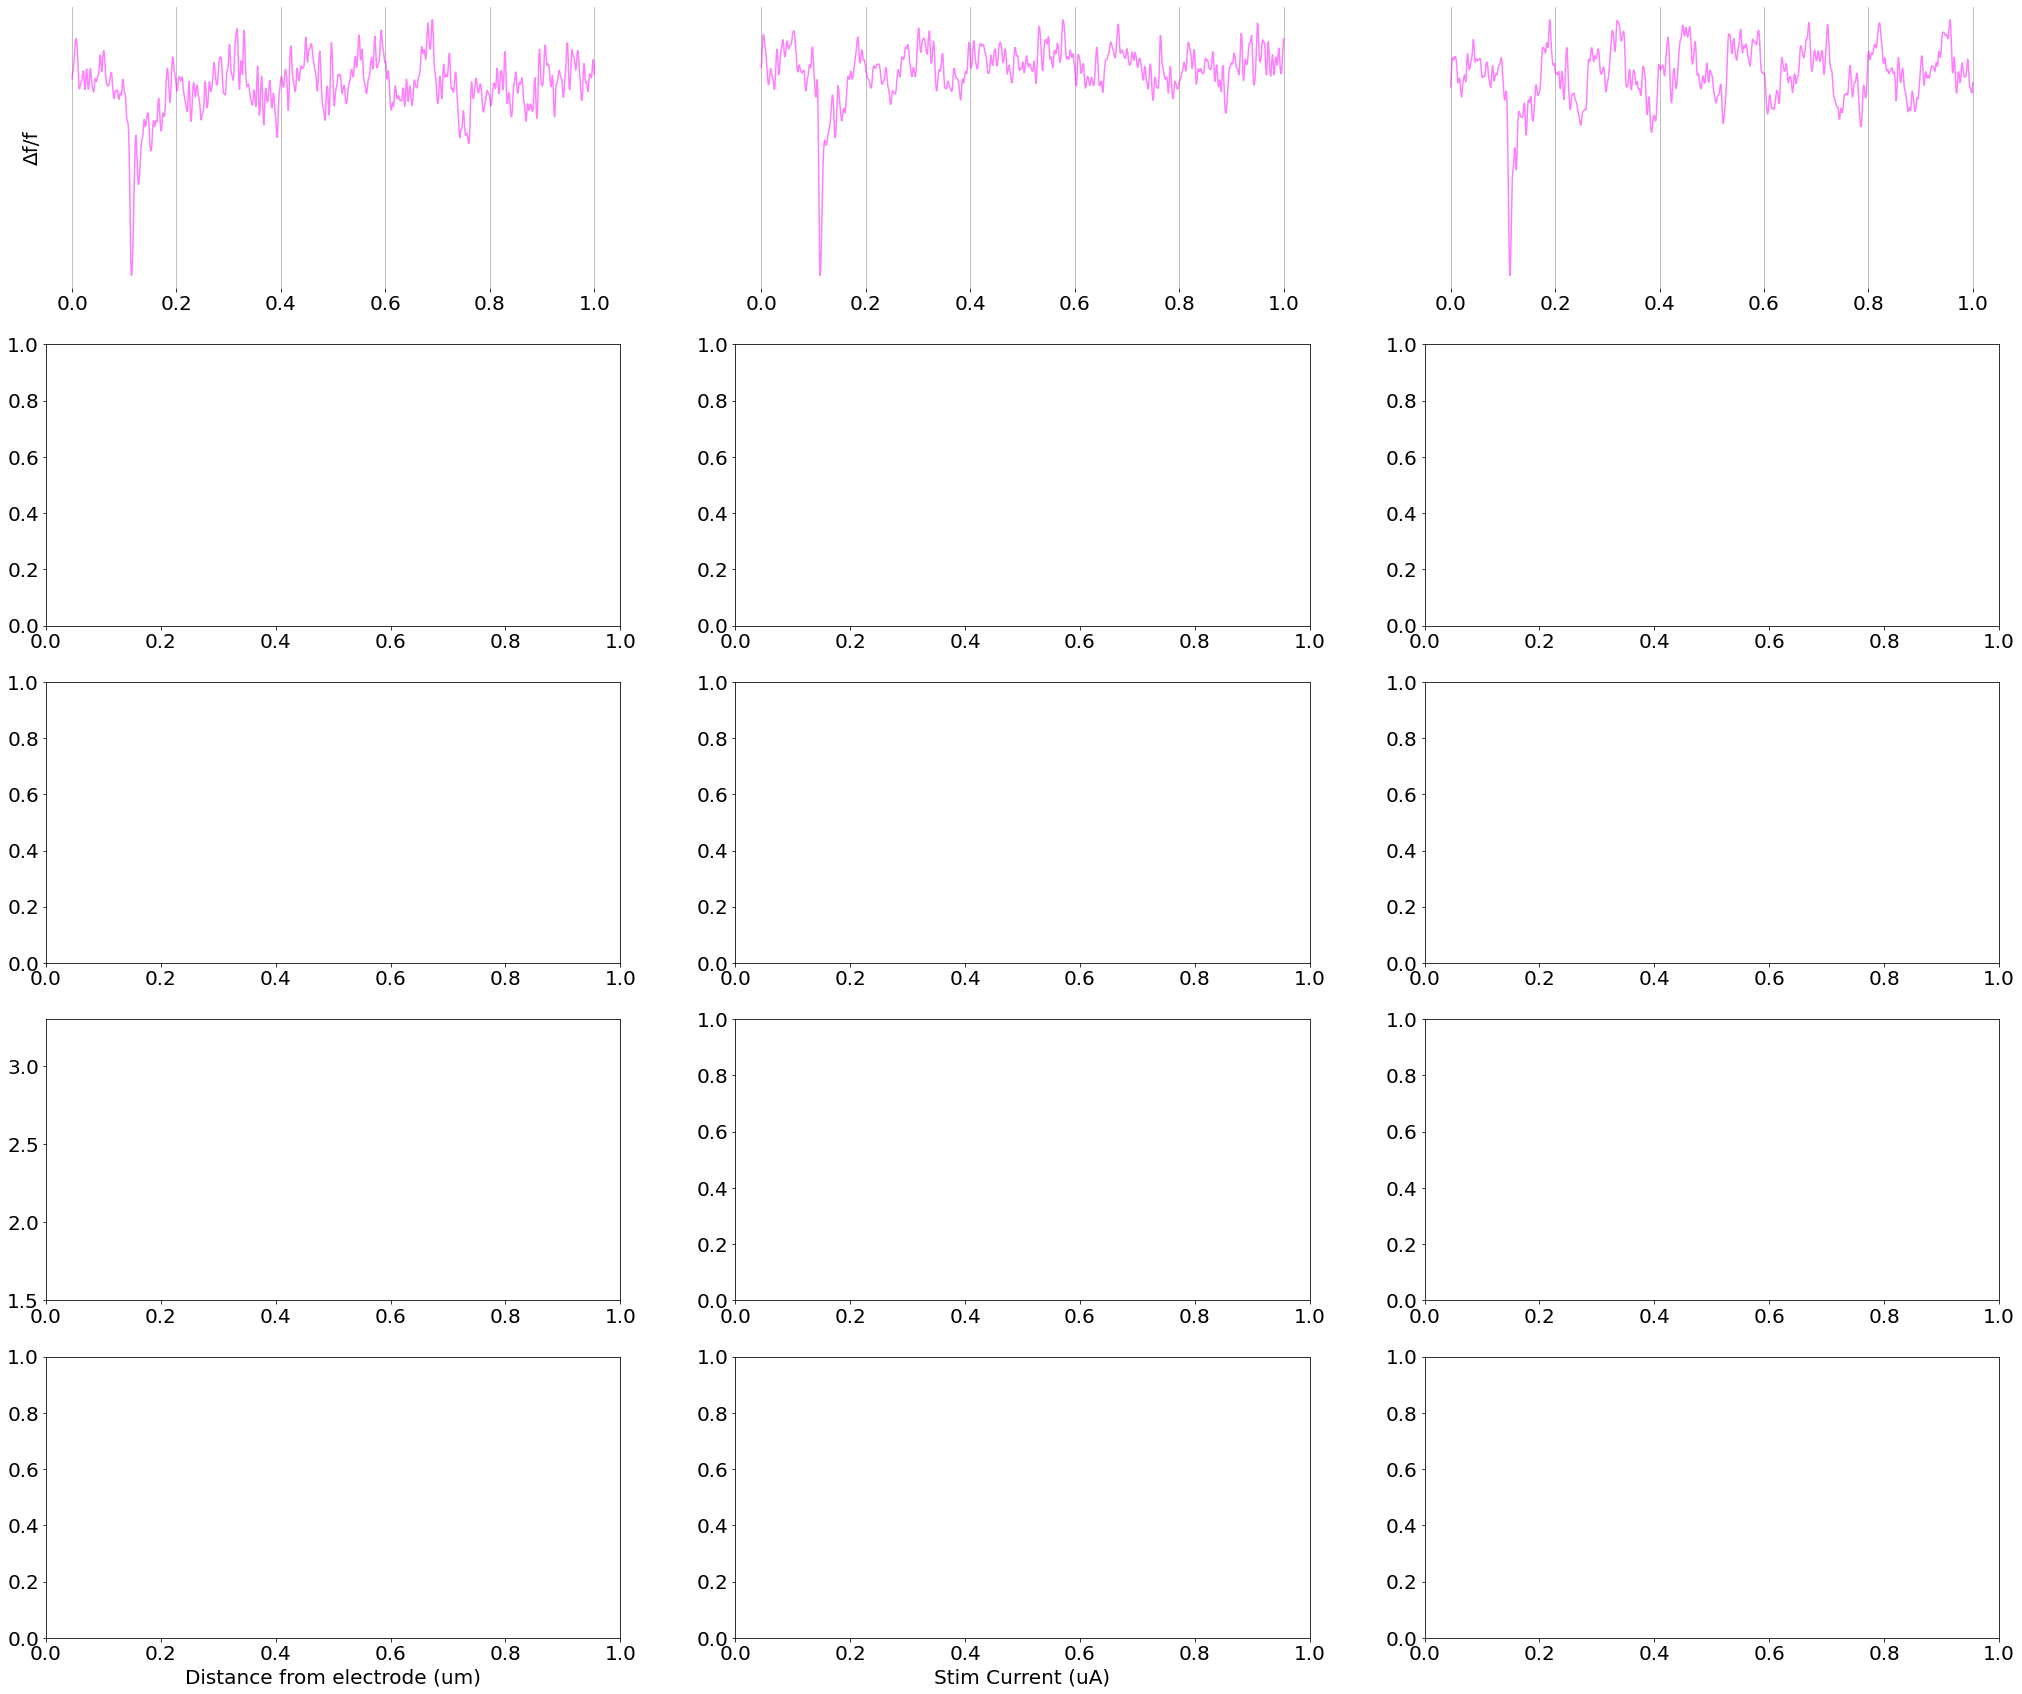

In [7]:
# set matplotlib font size to 16
plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots(5, 3, figsize=(35, 30))

roi_type = 'non_soma'

# color list from cold to hot
stim_color_map = {
    60: 'blue',
    70: 'cyan',
    80: 'green',
    100: 'orange',
    120: 'red',
    200: 'magenta'
}
stim_legend = {}
stim_order = list(stim_color_map.keys())
stim_order.sort()
print(stim_order, stim_order.index(80))

ax[4, 0].set_xlabel("Distance from electrode (um)")
ax[4, 1].set_xlabel("Stim Current (uA)")
ax[3, 0].set_ylim(1.5, 3.3)
headroom = 1.8
for date in df['Date'].unique():
    if "PP" in date:
        continue
    df_date = df[df['Date'] == date]
    print(date)
    date = parse_date(date, long_year=True).replace("-", "/")

    print(date)
    for slic_id in df_date['Slice'].unique():
        df_slic = df_date[df_date['Slice'] == slic_id]
        for loc_id in df_slic['Location'].unique():
            df_loc = df_slic[df_slic['Location'] == loc_id]
            for i, rec_id in enumerate(df_loc['Recording'].unique()):
                df_rec = df_loc[df_loc['Recording'] == rec_id]
                
                # use catalog to tell what stim current was used
                catalog_df_subset = catalog_df[(catalog_df['Date'] == date) &
                                                (catalog_df['Slice'] == slic_id) &
                                                (catalog_df['Loc'] == loc_id) & 
                                                (catalog_df['Recording'] ==  rec_id)]
                stim_current = catalog_df_subset['Stim_Current'].values[0]
                electrode_type = catalog_df_subset['Electrode_Type'].values[0]

                trace_filename = df_rec['trace'].values[0]  # all rois for this recording are in the same trace file
                sample_traces = read_traces_file(trace_filename)
    
                if electrode_type == 'single':
                    color = stim_color_map[stim_current]

                    # plot the first three traces in the 3 plots of the first row
                    for j, col_name in enumerate(sample_traces.columns[1:4]):
                        x = np.linspace(0, 1, len(sample_traces['Pt']))

                        y_loc = headroom * stim_order.index(stim_current)
                        ax[0, j].plot(x, -sample_traces[col_name] + y_loc, color=color, alpha=0.5)
                        ax[0, 0].set_ylabel("Δf/f")
                        ax[0, j].set_yticks([])
                        #ax[0, j].set_xlabel("Time (ms)")
                        ax[0, j].grid(True)
                        ax[0, j].spines['top'].set_visible(False)
                        ax[0, j].spines['right'].set_visible(False)
                        ax[0, j].spines['bottom'].set_visible(False)
                        ax[0, j].spines['left'].set_visible(False)


                # plot latency vs distance, half-width vs distance, max-amp time, and amplitude vs distance
                # each amplitude has a different color
                # scatter plot in the first column
                for i_plotrow, response_type in enumerate(['amp', 'latency', 'halfwidth']):
                    i_plotrow += 2
                    subset_df4 = df_rec[(df_rec[response_type] > 0) & 
                                            (df_rec['amp'] > 0.03)]
                    j_roi = 0
                    
                    # linear regression for this stim current subset
                    slope, intercept, r_value, p_value, std_err = linregress(subset_df4['Distance'], subset_df4[response_type])
                    
                
                    handle = ax[i_plotrow, j_roi].scatter(subset_df4['Distance'], subset_df4[response_type], 
                                            color=stim_color_map[stim_current], 
                                            label=subset_df4['Stim_Current'].values[0],
                                            alpha=0.5)
                    if p_value > 0.1 and response_type == 'Value_lat':
                        continue
                    
                    # plot the linear regression line
                    x = np.linspace(min(subset_df4['Distance']), max(subset_df4['Distance']), 100)
                    y = slope * x + intercept
                    ax[i_plotrow, j_roi].plot(x, y, color=stim_color_map[stim_current], alpha=0.5)

                    # label the linear regression line with the slope and p-value

                    y_annotation = i * 1/7
                    x_annotation = .84
                    xyc = 'axes fraction'
                    if response_type == 'Value' or response_type == 'Value_hw':
                        y_annotation = slope * min(subset_df4['Distance']) + intercept
                        x_annotation = min(subset_df4['Distance']  )
                        xyc = 'data'
                    if response_type == 'Value_lat':
                        y_annotation = slope * np.mean(subset_df4['Distance']  ) + intercept + 0.1
                        x_annotation = np.mean(subset_df4['Distance']  )
                        xyc = 'data'

                    ax[i_plotrow, j_roi].annotate(f"p = {p_value:.2f}", 
                                            (x_annotation, y_annotation),
                                            color=stim_color_map[stim_current],
                                            xycoords=xyc)

                    stim_legend[stim_current] = handle                            
                    ax[i_plotrow, 0].set_ylabel({'Value' : 'Δf/f', 
                                                'Value_hw': 'Half-width (ms)', 
                                                'Value_lat': 'Latency (ms)', 
                                                'Max_Amp_Time': 'Time to peak (ms)'}[response_type])
                    
                    # in the 2nd column, plot slope vs stim current as a bar plot
                    if response_type == 'Value_lat':
                        ax[i_plotrow, 1].bar(stim_current, slope, color=stim_color_map[stim_current])
                        ax[i_plotrow, 1].set_ylabel("Slope (ms/um)")
                        ax[i_plotrow, 1].set_ylim(0, 0.05)
                        ax[i_plotrow, 1].set_xticks(list(stim_legend.keys()))
                        ax[i_plotrow, 1].set_xticklabels(list(stim_legend.keys()))
                        ax[i_plotrow, 1].grid(True)
                    elif response_type == 'Value':
                        ax[i_plotrow, 1].bar(stim_current, slope, color=stim_color_map[stim_current])
                        ax[i_plotrow, 1].set_ylabel("Slope (/um)")
                        ax[i_plotrow, 1].set_xticks(list(stim_legend.keys()))
                        ax[i_plotrow, 1].set_xticklabels(list(stim_legend.keys()))
                        ax[i_plotrow, 1].grid(True)
                    elif response_type == 'Value_hw':
                        ax[i_plotrow, 1].bar(stim_current, slope, color=stim_color_map[stim_current])
                        ax[i_plotrow, 1].set_ylabel("Slope (ms/um)")
                        ax[i_plotrow, 1].set_xticks(list(stim_legend.keys()))
                        ax[i_plotrow, 1].set_xticklabels(list(stim_legend.keys()))
                        ax[i_plotrow, 1].grid(True)

                    # in the last column, plot intercept vs stim current as a bar plot
                    if response_type == 'Value_lat':
                        ax[i_plotrow, 2].bar(stim_current, intercept, color=stim_color_map[stim_current])
                        ax[i_plotrow, 2].set_ylabel("Intercept (ms)")
                        ax[i_plotrow, 2].set_xticks(list(stim_legend.keys()))
                        ax[i_plotrow, 2].set_xticklabels(list(stim_legend.keys()))
                        ax[i_plotrow, 2].grid(True)
                    elif response_type == 'Value':
                        ax[i_plotrow, 2].bar(stim_current, intercept, color=stim_color_map[stim_current])
                        ax[i_plotrow, 2].set_ylabel("Intercept (Δf/f)")
                        ax[i_plotrow, 2].set_xticks(list(stim_legend.keys()))
                        ax[i_plotrow, 2].set_xticklabels(list(stim_legend.keys()))
                        ax[i_plotrow, 2].grid(True)
                    elif response_type == 'Value_hw':
                        ax[i_plotrow, 2].bar(stim_current, intercept, color=stim_color_map[stim_current])
                        ax[i_plotrow, 2].set_ylabel("Intercept (ms)")
                        ax[i_plotrow, 2].set_xticks(list(stim_legend.keys()))
                        ax[i_plotrow, 2].set_xticklabels(list(stim_legend.keys()))
                        ax[i_plotrow, 2].grid(True)
handle_keys = list(stim_legend.keys())
handle_keys.sort()
handles = [stim_legend[k] for k in handle_keys]
ax[2, 0].legend(handles=handles, title="Stim Current (uA)")

ax[1, 0].set_ylabel("Δf/f")
ax[3, 0].set_ylim(0.5, 10.3)
#plt.savefig("P:/John/crossing-paper/input/output-cal-crl-theta-" + roi_type + ".png")
plt.show()


                        

## 